In [185]:


import pywt
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
from PIL import Image
import urllib.request
import io
import torch
from torch.autograd import Variable

URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Zuse-Z4-Totale_deutsches-museum.jpg/315px-Zuse-Z4-Totale_deutsches-museum.jpg'



(256, 256)


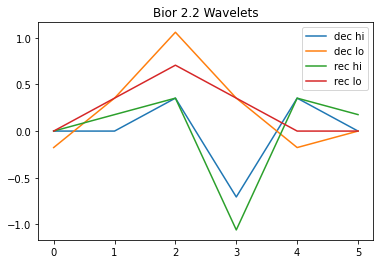

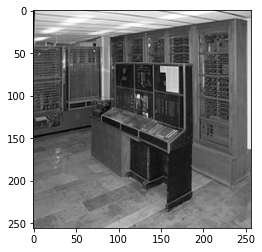

In [174]:
w=pywt.Wavelet('bior2.2')
#w=pywt.Wavelet('db3')
pyplot.plot(w.dec_hi[::-1], label="dec hi")
pyplot.plot(w.dec_lo[::-1], label="dec lo")
pyplot.plot(w.rec_hi, label="rec hi")
pyplot.plot(w.rec_lo, label="rec lo")
pyplot.title("Bior 2.2 Wavelets")
pyplot.legend()
dec_hi = torch.Tensor(w.dec_hi[::-1]) 
dec_lo = torch.Tensor(w.dec_lo[::-1])
rec_hi = torch.Tensor(w.rec_hi)
rec_lo = torch.Tensor(w.rec_lo)



imgraw = Image.open(io.BytesIO(urllib.request.urlopen(URL).read())).resize((256,256))
img = numpy.array(imgraw).mean(2)/255
print(img.shape)
img = torch.from_numpy(img).float()
pyplot.figure()
pyplot.imshow(img, cmap=pyplot.cm.gray)



In [168]:
filters = torch.stack([dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)], dim=0)

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)


In [178]:
def wt(vimg, levels=1):
    h = vimg.size(2)
    w = vimg.size(3)
    padded = torch.nn.functional.pad(vimg,(2,2,2,2), 'constant')
    print(padded.shape)
    res = torch.nn.functional.conv2d(padded, filters[:,None],stride=2)
    if levels>1:
        res[:,:1] = wt(res[:,:1],levels-1)
    res = res.view(-1,2,h//2,w//2).transpose(1,2).contiguous().view(-1,1,h,w)
    return res


In [179]:
def iwt(vres, levels=1):
    h = vres.size(2)
    w = vres.size(3)
    res = vres.view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    if levels>1:
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, inv_filters[:,None],stride=2)
    res = res[:,:,2:-2,2:-2]
    return res


torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 132, 132])
torch.Size([1, 1, 68, 68])
torch.Size([1, 1, 36, 36])


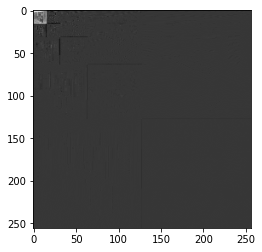

In [180]:


vimg = Variable(img[None,None])
res = wt(vimg,4)
pyplot.figure()
pyplot.imshow(res[0,0].data.numpy(),cmap=pyplot.cm.gray)


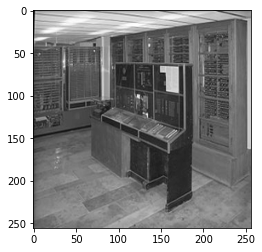

In [181]:
rec = iwt(res, levels=4)
pyplot.imshow(rec[0,0].data.numpy(),cmap=pyplot.cm.gray)

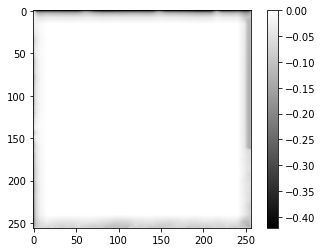

In [182]:
pyplot.imshow((rec-vimg).data[0,0].numpy(), cmap=pyplot.cm.gray)
pyplot.colorbar()

In [183]:
import torch


def fft2(data, real=False):
    """
    Apply centered 2 dimensional Fast Fourier Transform.
    Args:
        :param data (torch.Tensor): Complex valued input data containing at least 3 dimensions: dimensions
            -2 & -1 are spatial dimensions and dimension -3 has size 1 or 2. All other dimensions are
            assumed to be batch dimensions -> Typically size B x 1 or 2 x H x W
        :param real
    Returns:
        :return torch.Tensor: The 2D FFT of the input, with dimension B x 2 x H x W
    """
    data = data.repeat(1, 2, 1, 1)
    data[:, 1] *= 0
    data = ifftshift(data, dim=(-2, -1))
    if not real:
        assert data.size(-3) == 2
        data = torch.fft(ctoend(data), 2, normalized=True)
    else:
        assert data.size(-3) == 1
        data = torch.rfft(data, 2, normalized=True, onesided=False).squeeze(-4)
    data = fftshift(data, dim=(-3, -2))
    return cto1(data)


def ifft2(data, real=False):
    """
    Apply centered 2-dimensional Inverse Fast Fourier Transform.
    Args:
        :param data (torch.Tensor): Complex valued input data with at least 3 dimensions, typically of dimension
            B x 2 x H x W
        :param real
    Returns:
        :return torch.Tensor: The IFFT of the input, with dimension B x 1 or 2 x H x W
    """
    assert data.size(-3) == 2, data.shape
    data = ctoend(data)
    data = ifftshift(data, dim=(-3, -2))
    if not real:
        data = torch.ifft(data, 2, normalized=True)
        data = cto1(data)
    else:
        data = torch.irfft(data, 2, normalized=True, onesided=False).unsqueeze(-3)
    data = fftshift(data, dim=(-2, -1))
    return data[:, 0]


def roll(x, shift, dim):
    """
    Similar to np.roll but applies to PyTorch Tensors
    :param x: pt.Tenser to be shifted
    :param dim: dimensions to shift along
    """
    if isinstance(shift, (tuple, list)):
        assert len(shift) == len(dim)
        for s, d in zip(shift, dim):
            x = roll(x, s, d)
        return x
    shift = shift % x.size(dim)
    if shift == 0:
        return x
    left = x.narrow(dim, 0, x.size(dim) - shift)
    right = x.narrow(dim, x.size(dim) - shift, shift)
    return torch.cat((right, left), dim=dim)


def cto1(x):
    """
    Args:
        :param x (tensor) with three last dimensions H x W x (1 or 2)
    Returns:
        :return tensor with three last dimensions (1 or 2) x H x W
    """
    return x.transpose(-3, -1).transpose(-1, -2)

def ctoend(x):
    """
    Args:
        :param x (tensor) with three last dimensions (1 or 2) x H x W
    Returns:
        :return tensor with three last dimensions H x W x (1 or 2)
    """
    return x.transpose(-3, -1).transpose(-3, -2)

def fftshift(x, dim=None):
    """
    Similar to np.fft.fftshift but applies to PyTorch Tensors
    :param x: pt.Tenser to be shifted
    :param dim: dimensions to shift along
    :return:
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [dim // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = x.shape[dim] // 2
    else:
        shift = [x.shape[i] // 2 for i in dim]
    return roll(x, shift, dim)


def ifftshift(x, dim=None):
    """
    Similar to np.fft.ifftshift but applies to PyTorch Tensors
    :param x: pt.Tenser to be shifted
    :param dim: dimensions to shift along
    :return:
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [(dim + 1) // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = (x.shape[dim] + 1) // 2
    else:
        shift = [(x.shape[i] + 1) // 2 for i in dim]
    return roll(x, shift, dim)


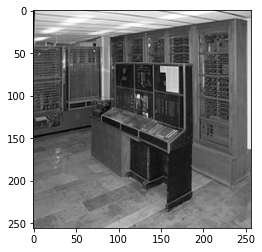

torch.Size([1, 2, 256, 256])


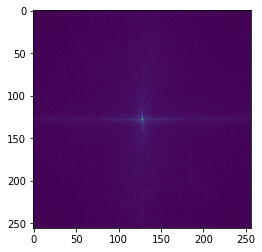

torch.Size([1, 2, 260, 260])


RuntimeError: Given groups=1, weight of size [4, 1, 6, 6], expected input[1, 2, 260, 260] to have 1 channels, but got 2 channels instead

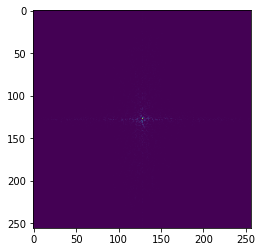

In [199]:
plt.imshow(img, cmap='gray')
plt.show()

fft2img = fft2(img)
print(fft2img.shape)
plt.imshow(torch.sqrt(fft2img[0, 0]**2 + fft2img[0, 1]**2)**0.5)
plt.show()
mask = torch.zeros((256, 256)) + 0.4
mask = torch.bernoulli(mask)


fft2imgmask = mask * fft2img
plt.imshow(torch.sqrt(fft2imgmask[0, 0]**2 + fft2imgmask[0, 1]**2))

